In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deeplake[enterprise]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.5 MB/s eta 0

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
train_ds = deeplake.load('hub://activeloop/nih-chest-xray-train')
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



/

hub://activeloop/nih-chest-xray-train loaded successfully.



Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



-

hub://activeloop/nih-chest-xray-test loaded successfully.



In [ ]:
train_ds, val_ds = train_ds.random_split([0.9, 0.1])

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

77872
8652
25596


In [ ]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomRotation(8),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

train_loader = train_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(True)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

val_loader = val_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [ ]:
def save_results_to_file(result_file, train_loss, val_loss, micro_auc, macro_auc, per_class_auc_scores):
  with open(result_file, 'a') as f:
    f.write(f'{train_loss}, {val_loss}, {micro_auc}, {macro_auc},')

    for auc_score in per_class_auc_scores:
      f.write(f' {auc_score},')

    f.write('\n')

In [ ]:
def eval_one_epoch(model, criterion, data_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  running_val_loss = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      all_preds.append(outputs)
      all_labels.append(labels)

      loss = criterion(outputs, labels)
      running_val_loss += loss.item() * inputs.shape[0]

  val_average_loss = running_val_loss / len(data_loader.dataset)
  print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

  all_preds = torch.cat(all_preds, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  all_preds = all_preds.cpu().numpy()
  all_labels = all_labels.cpu().numpy()

  micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
  print(f'Micro-averaged ROC AUC: {micro_auc_score}')

  macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
  print(f'Macro-averaged ROC AUC: {macro_auc_score}')

  num_labels = all_labels.shape[1]
  plt.figure(figsize=(10, 8))

  per_class_auc_scores = []

  for label_index in range(num_labels):
    try:
      auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
      per_class_auc_scores.append(auc_score)
      print(f'ROC AUC for label {label_index}: {auc_score}')

      fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
      plt.plot(fpr, tpr, label=f'Label {label_index} (AUC = {auc_score:.2f})')
    except ValueError:
      print(f'ROC AUC for label {label_index}: Not Defined (No positive examples in labels)')
      per_class_auc_scores.append(None)

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc="lower right")
  plt.show()

  return val_average_loss, micro_auc_score, macro_auc_score, per_class_auc_scores

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, val_data_loader, device):
  model.train()

  running_train_loss = 0

  for i, data in enumerate(data_loader):
    inputs = data['images']
    labels = data['findings']

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    running_train_loss += loss.item() * inputs.shape[0]

    loss.backward()
    optimizer.step()

    if i % 1000 == 999:
      print(f'Batch: {i + 1}/{len(data_loader)}')

  train_average_loss = running_train_loss / len(data_loader.dataset)
  print(f'Training phase completed. Average loss: {train_average_loss:.4f}')

  val_results = eval_one_epoch(model, criterion, val_data_loader, device)
  val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes = val_results

  return train_average_loss, val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes

In [ ]:
def class_averaged_binary_cross_entropy(preds, targets):
  num_classes = 15
  loss = 0

  for c in range(num_classes):
    loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c])
    loss += loss_c

  loss /= num_classes

  return loss

In [ ]:
def save_model(result_file_model, model, model_name, epoch):
  model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
  torch.save(model.state_dict(), model_save_path)
  print(f'Model saved at {model_save_path}')

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

num_ftrs = model.fc.in_features
num_labels = 15

model.fc = nn.Sequential(
  nn.Linear(2048, 1000),
  nn.ReLU(),
  nn.Linear(1000, num_labels),
  nn.Sigmoid()
)

for name, param in model.named_parameters():
  if ('layer3' in name) or ('layer4' in name) or ('fc' in name):
    param.requires_grad = True
  else:
    param.requires_grad = False

for param in model.conv1.parameters():
  param.requires_grad = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

criterion = class_averaged_binary_cross_entropy
optimizer = optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001, betas=(0.9, 0.999))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


Running on cuda


------------------ Training Epoch 1 ------------------


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 2.00G/2.00G [00:19<00:00, 112MB/s] 


Shuffle buffer filling is complete.
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1870
Validation phase completed. Average loss: 0.1840
Micro-averaged ROC AUC: 0.8851522501698846
Macro-averaged ROC AUC: 0.7136310615720498
ROC AUC for label 0: 0.7171051579368253
ROC AUC for label 1: 0.7904596503415537
ROC AUC for label 2: 0.7369171994568616
ROC AUC for label 3: 0.5777643466089832
ROC AUC for label 4: 0.660895231051607
ROC AUC for label 5: 0.7747985284382563
ROC AUC for label 6: 0.660092171656222
ROC AUC for label 7: 0.8402337353202638
ROC AUC for label 8: 0.6826879304095687
ROC AUC for label 9: 0.6894208282638277
ROC AUC for label 10: 0.702017222013358
ROC AUC for label 11: 0.7188639890609568
ROC AUC for label 12: 0.6930797822353574
ROC AUC for label 13: 0.6356921106558924
ROC AUC for label 14: 0.824438040131214


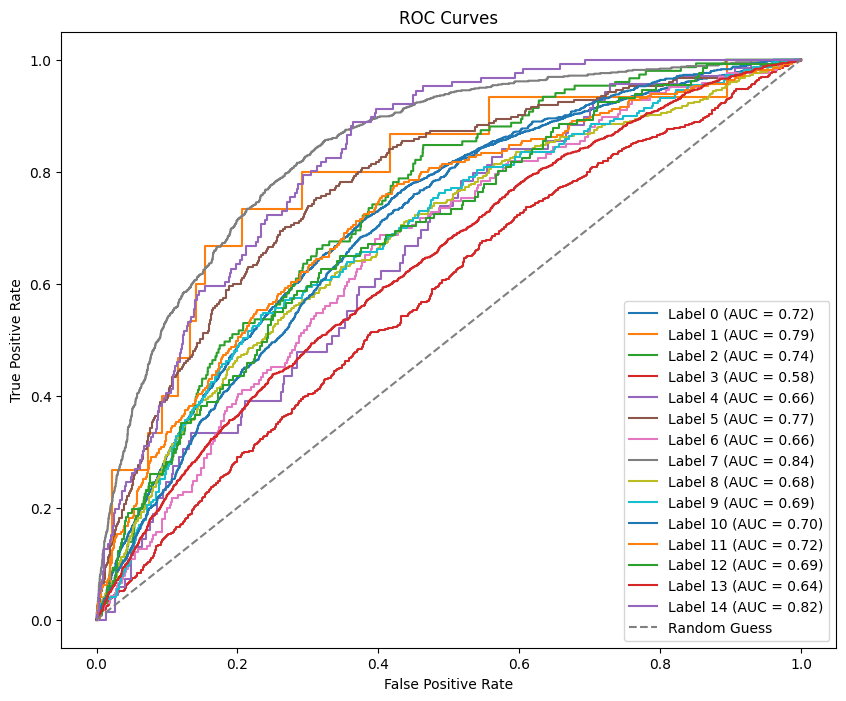

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_ResNet50_checkpoint_epoch_1.pt
------------------ Training Epoch 2 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1799
Validation phase completed. Average loss: 0.1808
Micro-averaged ROC AUC: 0.8934887635269326
Macro-averaged ROC AUC: 0.7348496541583844
ROC AUC for label 0: 0.7249995344328023
ROC AUC for label 1: 0.7553008374821505
ROC AUC for label 2: 0.7435323152476803
ROC AUC for label 3: 0.6061550098259604
ROC AUC for label 4: 0.7242079472904815
ROC AUC for label 5: 0.7741942765364038
ROC AUC for label 6: 0.7160780761509389
ROC AUC for label 7: 0.8561401944041548
ROC AUC for label 8: 0.7084868108412871
ROC AUC for label 9: 0.7257322965280452
ROC AUC for label 10: 0.7248817596576483
ROC AUC for label 11: 0.7448014585390735
ROC AUC for label 12: 0.7222681099501814
ROC AUC for label 13: 0.6464452057779705
ROC AUC for label 14: 0.84952097

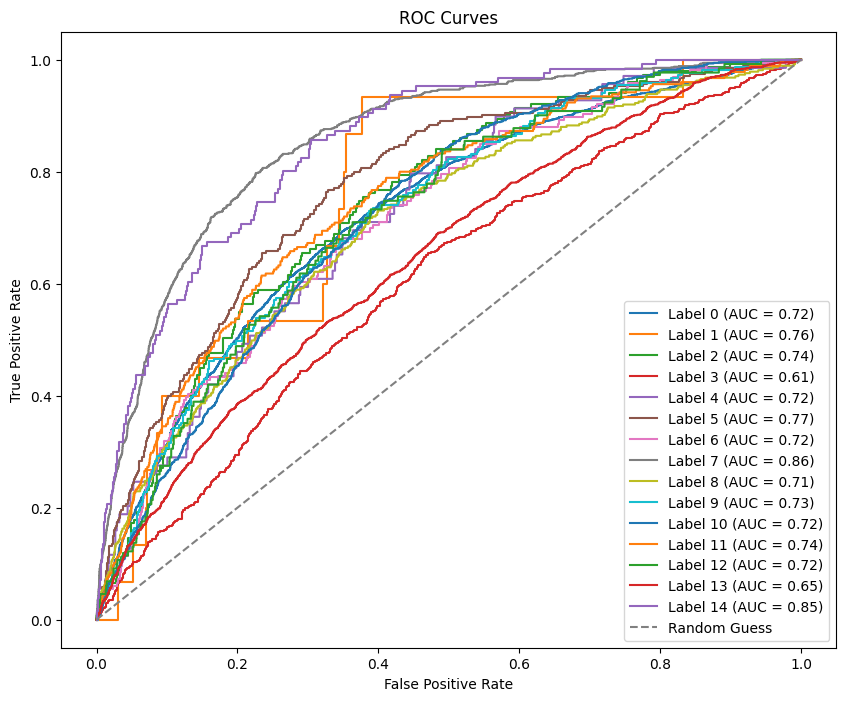

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_ResNet50_checkpoint_epoch_2.pt
------------------ Training Epoch 3 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1772
Validation phase completed. Average loss: 0.1785
Micro-averaged ROC AUC: 0.8956010428990854
Macro-averaged ROC AUC: 0.7432535914728807
ROC AUC for label 0: 0.7328008248755291
ROC AUC for label 1: 0.7772297479834819
ROC AUC for label 2: 0.7533433931808566
ROC AUC for label 3: 0.6206643244593365
ROC AUC for label 4: 0.7096518733526165
ROC AUC for label 5: 0.7761520179712851
ROC AUC for label 6: 0.7669041710088054
ROC AUC for label 7: 0.8661075743929256
ROC AUC for label 8: 0.7179354838709676
ROC AUC for label 9: 0.7185318386616614
ROC AUC for label 10: 0.7346702382444268
ROC AUC for label 11: 0.7535665838280139
ROC AUC for label 12: 0.6913337591634856
ROC AUC for label 13: 0.655888978125311
ROC AUC for label 14: 0.874023062

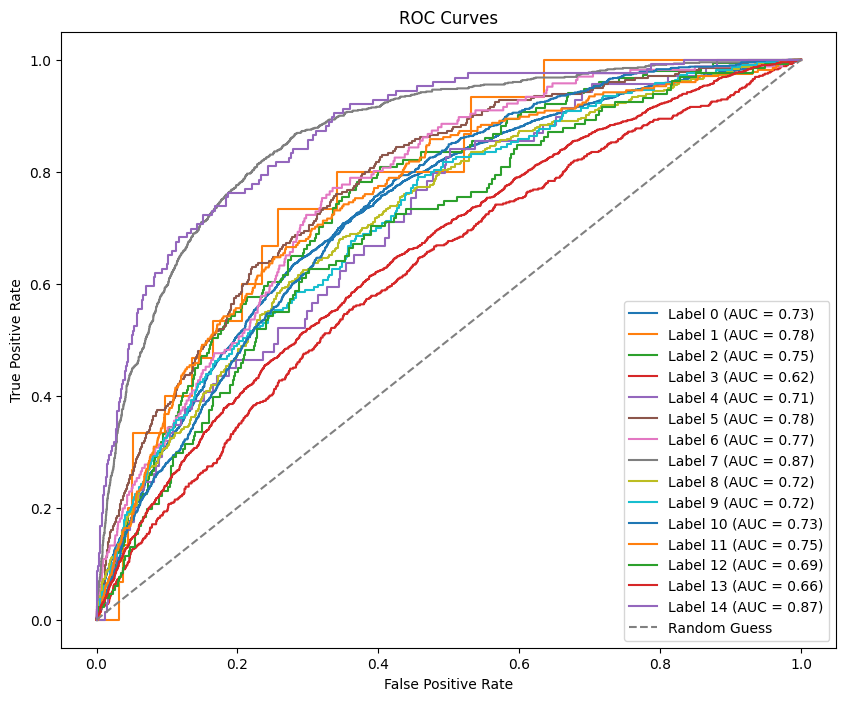

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_ResNet50_checkpoint_epoch_3.pt
------------------ Training Epoch 4 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1745
Validation phase completed. Average loss: 0.1770
Micro-averaged ROC AUC: 0.9024394992702651
Macro-averaged ROC AUC: 0.7613664007390722
ROC AUC for label 0: 0.7355723190175985
ROC AUC for label 1: 0.763312878700166
ROC AUC for label 2: 0.7882415080111338
ROC AUC for label 3: 0.6501769615397304
ROC AUC for label 4: 0.7143561505976593
ROC AUC for label 5: 0.7855782608223816
ROC AUC for label 6: 0.8620640942274874
ROC AUC for label 7: 0.8737984255836804
ROC AUC for label 8: 0.7513656316700899
ROC AUC for label 9: 0.730368356104822
ROC AUC for label 10: 0.744014735369063
ROC AUC for label 11: 0.7609638946465973
ROC AUC for label 12: 0.7182300396595389
ROC AUC for label 13: 0.662291604742752
ROC AUC for label 14: 0.880161150393

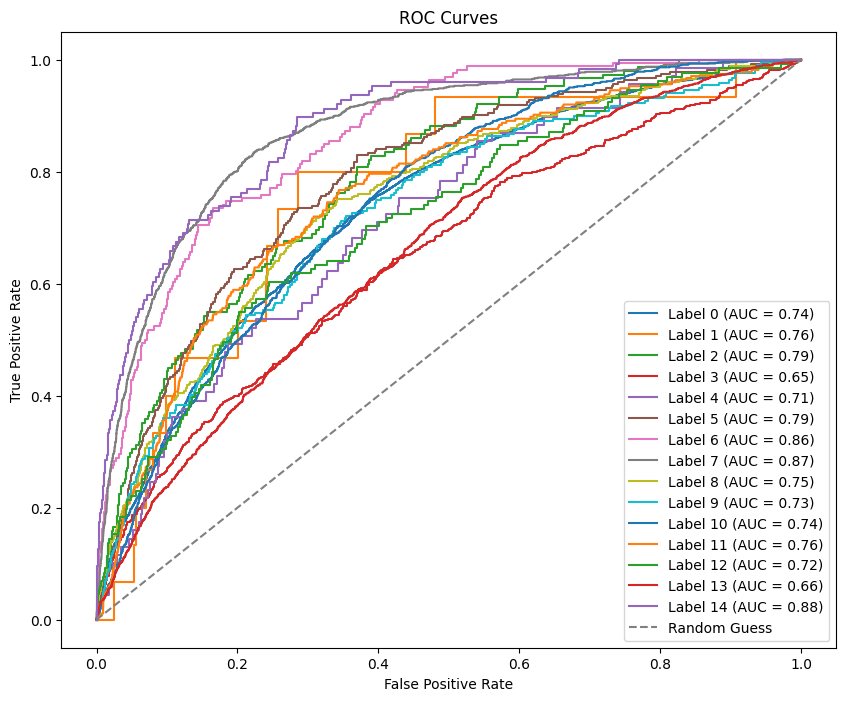

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_ResNet50_checkpoint_epoch_4.pt
------------------ Training Epoch 5 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1717
Validation phase completed. Average loss: 0.1748
Micro-averaged ROC AUC: 0.9015547550410694
Macro-averaged ROC AUC: 0.760182502783416
ROC AUC for label 0: 0.738332091820806
ROC AUC for label 1: 0.7359808575508472
ROC AUC for label 2: 0.7801653253103842
ROC AUC for label 3: 0.6722963292851319
ROC AUC for label 4: 0.6822620380360909
ROC AUC for label 5: 0.7828165865410703
ROC AUC for label 6: 0.8796181662781222
ROC AUC for label 7: 0.8688610484021897
ROC AUC for label 8: 0.7608123716322339
ROC AUC for label 9: 0.7333339830964134
ROC AUC for label 10: 0.7509306060310696
ROC AUC for label 11: 0.738684493255342
ROC AUC for label 12: 0.727313122227886
ROC AUC for label 13: 0.6637327354951588
ROC AUC for label 14: 0.887597786788

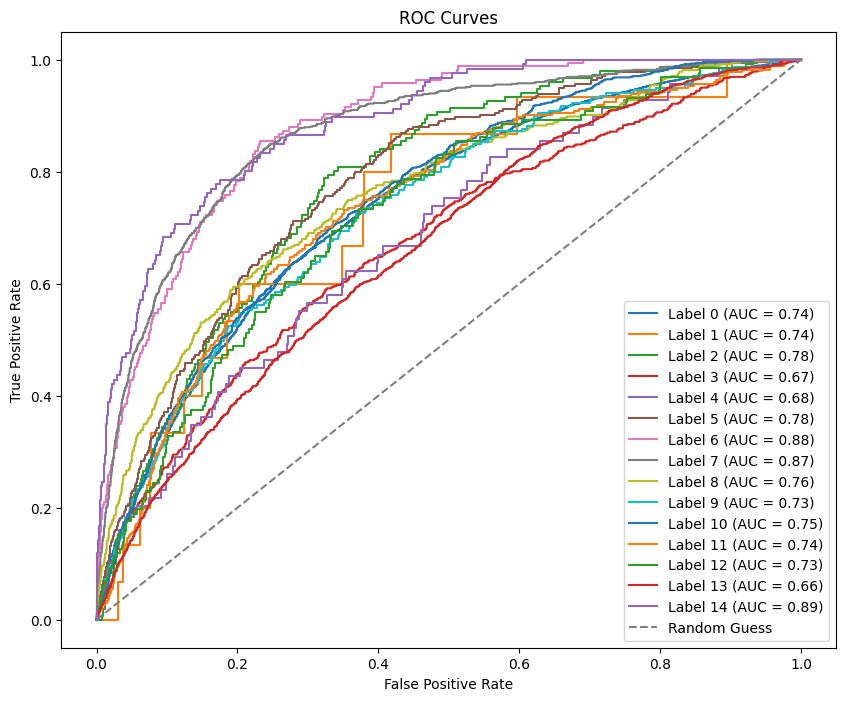

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_ResNet50_checkpoint_epoch_5.pt
------------------ Training Epoch 6 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1698
Validation phase completed. Average loss: 0.1751
Micro-averaged ROC AUC: 0.9017889886732448
Macro-averaged ROC AUC: 0.7702779276082453
ROC AUC for label 0: 0.7387240720150297
ROC AUC for label 1: 0.8082050094554437
ROC AUC for label 2: 0.7955487901306507
ROC AUC for label 3: 0.6811855244989231
ROC AUC for label 4: 0.6884860028333729
ROC AUC for label 5: 0.7716118810162023
ROC AUC for label 6: 0.8877059025638258
ROC AUC for label 7: 0.8756253509100267
ROC AUC for label 8: 0.7635479843743707
ROC AUC for label 9: 0.7441625555615116
ROC AUC for label 10: 0.7594224585868714
ROC AUC for label 11: 0.7723906367000553
ROC AUC for label 12: 0.7016083300261322
ROC AUC for label 13: 0.6667760453117477
ROC AUC for label 14: 0.89916837

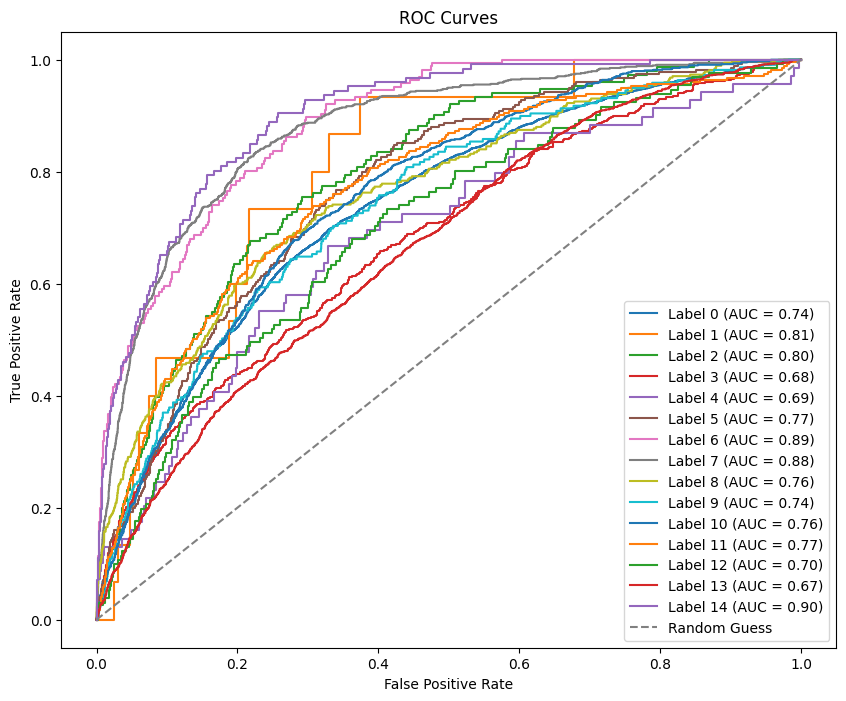

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_ResNet50_checkpoint_epoch_6.pt
------------------ Training Epoch 7 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1681
Validation phase completed. Average loss: 0.1712
Micro-averaged ROC AUC: 0.9084280766737555
Macro-averaged ROC AUC: 0.7815625458862111
ROC AUC for label 0: 0.7473901398344772
ROC AUC for label 1: 0.7996680946316237
ROC AUC for label 2: 0.8073417151546644
ROC AUC for label 3: 0.68068055967916
ROC AUC for label 4: 0.7240011009292046
ROC AUC for label 5: 0.7961815360239617
ROC AUC for label 6: 0.8902508454747579
ROC AUC for label 7: 0.8775535284003182
ROC AUC for label 8: 0.7907670250896057
ROC AUC for label 9: 0.7408836886183708
ROC AUC for label 10: 0.772354633420128
ROC AUC for label 11: 0.7921165094902709
ROC AUC for label 12: 0.7243272346452545
ROC AUC for label 13: 0.671689427993639
ROC AUC for label 14: 0.908232148907

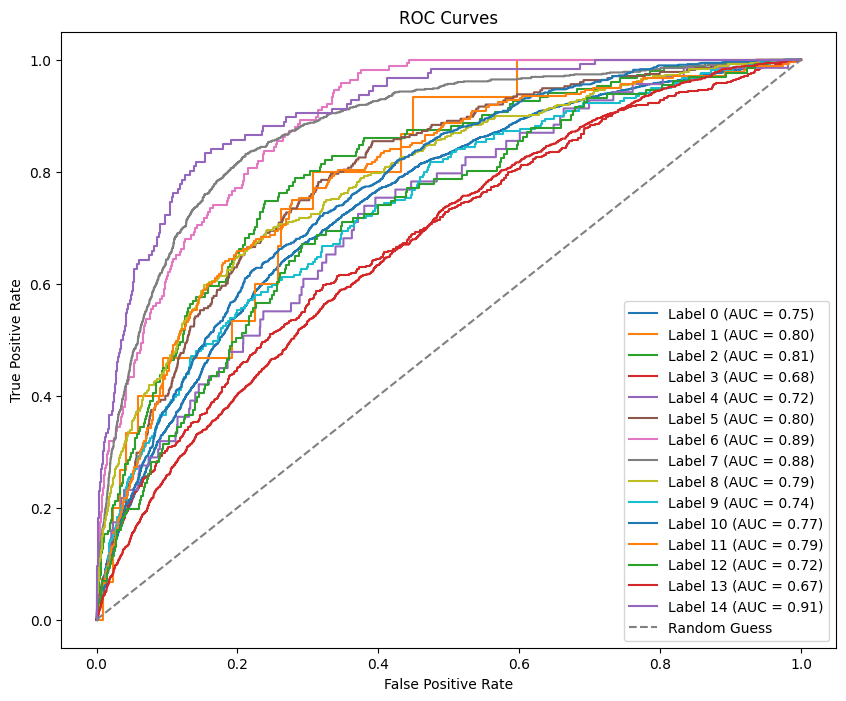

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_ResNet50_checkpoint_epoch_7.pt
------------------ Training Epoch 8 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1665
Validation phase completed. Average loss: 0.1712
Micro-averaged ROC AUC: 0.9082186330531634
Macro-averaged ROC AUC: 0.783708104178329
ROC AUC for label 0: 0.7485150871158386
ROC AUC for label 1: 0.8203234147659295
ROC AUC for label 2: 0.8105520893139959
ROC AUC for label 3: 0.6925942420343743
ROC AUC for label 4: 0.6988570261065438
ROC AUC for label 5: 0.7857117431929416
ROC AUC for label 6: 0.890274981613941
ROC AUC for label 7: 0.8800026610677023
ROC AUC for label 8: 0.8005779871934275
ROC AUC for label 9: 0.750770646086504
ROC AUC for label 10: 0.7759711024780577
ROC AUC for label 11: 0.7846386751603416
ROC AUC for label 12: 0.7278766155640621
ROC AUC for label 13: 0.6755317387470259
ROC AUC for label 14: 0.91342355223

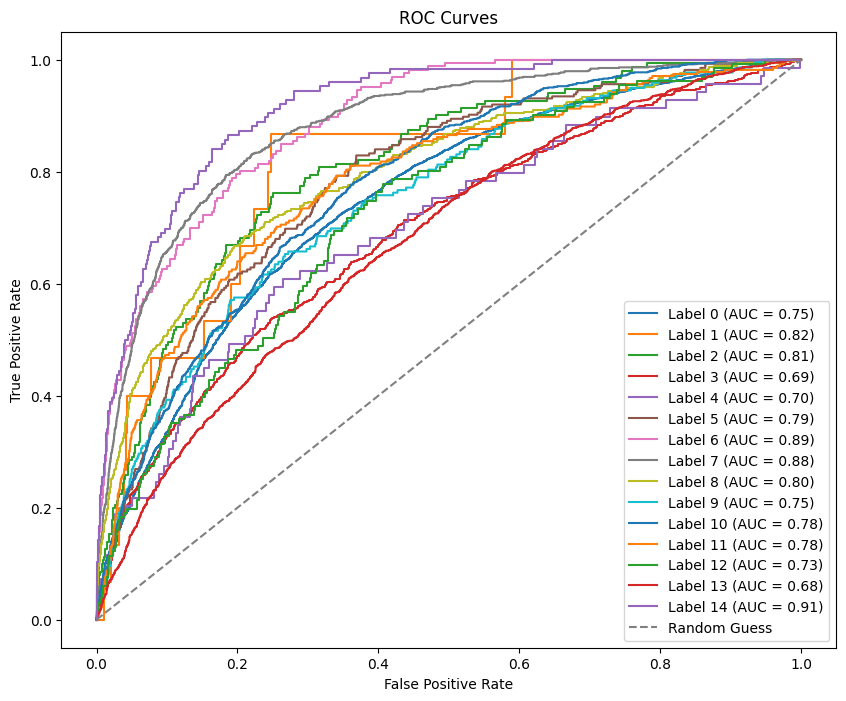

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_ResNet50_checkpoint_epoch_8.pt
------------------ Training Epoch 9 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1650
Validation phase completed. Average loss: 0.1712
Micro-averaged ROC AUC: 0.9083081995124784
Macro-averaged ROC AUC: 0.7863451277181369
ROC AUC for label 0: 0.7456486446517283
ROC AUC for label 1: 0.8299177955308557
ROC AUC for label 2: 0.8230991133882963
ROC AUC for label 3: 0.6959063211321768
ROC AUC for label 4: 0.7206071320625368
ROC AUC for label 5: 0.7790925369246964
ROC AUC for label 6: 0.8958511396517013
ROC AUC for label 7: 0.8783738536939129
ROC AUC for label 8: 0.8058162780395474
ROC AUC for label 9: 0.7664220850139183
ROC AUC for label 10: 0.7616344609679231
ROC AUC for label 11: 0.7886746177303655
ROC AUC for label 12: 0.7251460469016378
ROC AUC for label 13: 0.6686454135906857
ROC AUC for label 14: 0.91034147

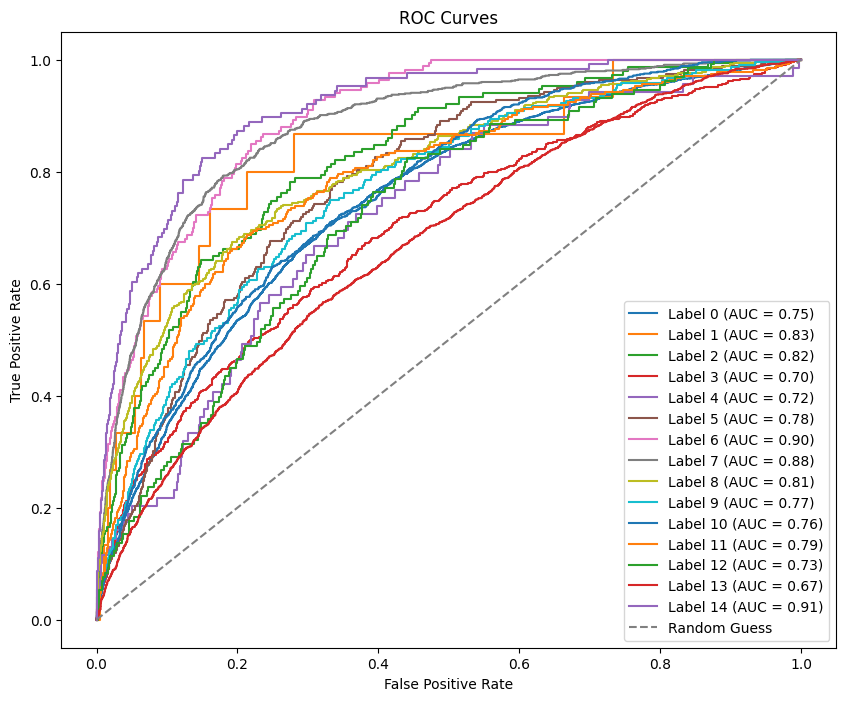

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_ResNet50_checkpoint_epoch_9.pt
------------------ Training Epoch 10 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1638
Validation phase completed. Average loss: 0.1726
Micro-averaged ROC AUC: 0.9091618776864884
Macro-averaged ROC AUC: 0.7859573227572895
ROC AUC for label 0: 0.7466449036823627
ROC AUC for label 1: 0.8067152946624986
ROC AUC for label 2: 0.8220310660763711
ROC AUC for label 3: 0.7083706814079634
ROC AUC for label 4: 0.7194859403573293
ROC AUC for label 5: 0.7816738472223729
ROC AUC for label 6: 0.8863762852494115
ROC AUC for label 7: 0.8747730781827537
ROC AUC for label 8: 0.8119276710563409
ROC AUC for label 9: 0.7596742954266966
ROC AUC for label 10: 0.7770313783644541
ROC AUC for label 11: 0.795785212757876
ROC AUC for label 12: 0.7181001405597844
ROC AUC for label 13: 0.6705412038582748
ROC AUC for label 14: 0.91022884

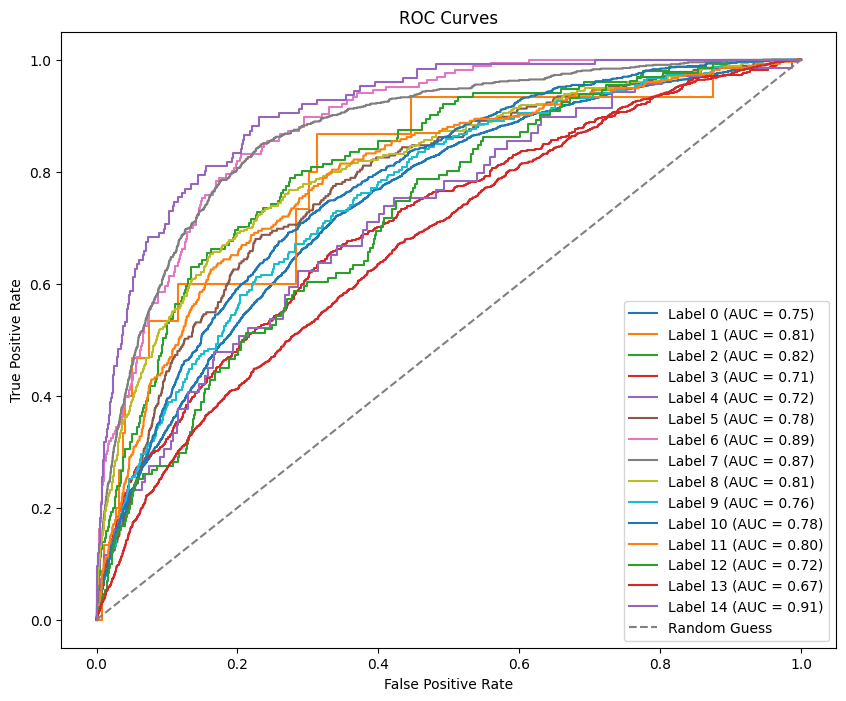

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_ResNet50_checkpoint_epoch_10.pt


In [ ]:
num_epochs = 10
model_name = "SSN_ResNet50"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
result_file_metrics = "/content/drive/MyDrive/SSN_Projekt/Metrics/SSN_ResNet50.txt"

for epoch in range(num_epochs):
  print(f"------------------ Training Epoch {epoch + 1} ------------------")
  train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores = train_one_epoch(model, optimizer, criterion, train_loader, val_loader, device)
  save_results_to_file(result_file_metrics, train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores)

  save_model(result_file_model, model, model_name, epoch + 1)